In [1]:
import numpy as np 
import pandas as pd 
import os
import torch
import librosa
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import ast

# Memory monitor
from my_memory_profiler import profile

<h4>Calcular Extension</h4>

In [2]:
def calculate_extension(data_dir, sample_rate, time_leng=0.4, overlap=2, amplitude_threshold=0.3):

    def label_generator(data_dir):
        data_list = []
        
        for dirname, _, filenames in os.walk(data_dir):
            for filename in filenames:
                if filename.endswith('.wav'):  
                    identifiers = filename.split('.')[0].split('_')
                    Speaker_ID = int(identifiers[-1])
                    Label = 1 if identifiers[0] == 'PD' else 0
                    data_list.append({
                        "Speaker_ID": Speaker_ID,
                        "Label": Label,
                        "FileName": filename
                    })
        
        audio_labels = pd.DataFrame(data_list)
            
        return audio_labels
    
    def num_seg(data_dir,
                audio_labels,
                SAMPLE_RATE,
                time_leng,
                overloap,
                amplitude_threshold,
                output_csv=None,
                filenames=False):
        
        sample_leng=int(time_leng*SAMPLE_RATE)
        segments_info=[]
        

        for data_ind, audio_label in enumerate(audio_labels.values):
            seg_starts=[]
            file_name=audio_label[-1]
            data_path=os.path.join(data_dir, file_name)
            audio, sample_rate = librosa.load(data_path, sr=SAMPLE_RATE)
            audio_len=len(audio)
            audio=audio/np.max(abs(audio))
            indx=[]
            indx=[i for i,x in enumerate(np.sqrt(abs(audio))) if x>amplitude_threshold]
            
            segments=0
            

            if (indx[0]+sample_leng)<audio_len:
                for i in range(int((-indx[0]+indx[len(indx)-1])/(sample_leng/overloap))):
                    ind_start = i * int(sample_leng/overloap)+indx[0]
                    ind_end = ind_start + sample_leng
                    if ind_end <= indx[-1]:
                        segments+=1
                        seg_starts.append(ind_start)
                        
                segment_info = {
                    'Segments': segments,
                    'Seg_starts': seg_starts
                }
                if filenames:
                    segment_info['Filename'] = file_name
                segments_info.append(segment_info)
            else:
                segment_info = {
                    'Segments': segments,
                    'Seg_starts': seg_starts
                }
                if filenames:
                    segment_info['Filename'] = file_name
                segments_info.append(segment_info)           

            if (data_ind+1)==1 : print(" Processing files...",end='\n')
            if (data_ind+1)%50==0 : print(" Processed {}/{} files".format(data_ind+1,len(audio_labels)),end='\n')
        
        df_segments = pd.DataFrame(segments_info)
        if(output_csv is None):
            return df_segments
        else:
            df_segments.to_csv(output_csv, index=False)
    
    labels=label_generator(data_dir)
    segments=num_seg(data_dir, labels, sample_rate, time_leng, overlap,amplitude_threshold)
    extension_DB=pd.concat([labels, segments], axis=1)
    extension_DB.to_csv('extension.csv', index=False)
    print("Se ha creado el fichero extension.csv en el cwd")

<h4>Funciones de preprocesado</h4>

In [3]:
def process_select_signal(data_path,
                            sample_rate,
                            seg_start,
                            time_length,
                            overlap_factor):
    
    audio, _ = librosa.load(data_path, sr=sample_rate)
    audio_len = len(audio)
    audio = audio / np.max(np.abs(audio)) 

    sample_length = int(time_length * sample_rate)
    overlap = overlap_factor

    ind_end = seg_start + sample_length
    signal = np.zeros(sample_length)
    signal = audio[seg_start:int(ind_end)]

    return signal

def to_spectrogram(signal, sample_rate):
    n_fft = 2048
    win_length = int(0.015*sample_rate) 
    hop_length = int(0.010*sample_rate)
    n_mels = 65 

    mel_spectrogram = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm="slaney",
        n_mels=n_mels,
        mel_scale="htk",
    )

    scaler = StandardScaler()
    
    mel_spect = librosa.power_to_db(mel_spectrogram(torch.from_numpy(signal)))
    mel_spect_norm=scaler.fit_transform(mel_spect)
    
    return mel_spect_norm


<h4>Definición del Dataset</h4>

In [4]:
class CustomAudioDataset(Dataset):

    def __init__(self, data_dir, sample_rate, time_leng, overlap, amplitude_threshold=0.3, to_spectrogram=False, have_extension=True):
        
        if have_extension is False:
            calculate_extension(data_dir, sample_rate, time_leng, overlap, amplitude_threshold)
        try:
            extension = pd.read_csv('extension.csv')
            extension.Seg_starts=extension.Seg_starts.apply(ast.literal_eval) # convertir string a lista
        except Exception:
            raise FileNotFoundError("No tiene extension.csv en el cwd, cambie su nombre o localización o marque have_extension=False")

        
        self.labels=extension['Label'].values
        self.IDs=extension['Speaker_ID'].values
        self.filenames=extension['FileName'].values
        self.num_segs=extension['Segments'].values
        self.spec_id_to_file_id = np.concatenate([np.full(count, idx) for idx, count in enumerate(self.num_segs)])
        

        # sample rate y path al directorio
        self.sample_rate=sample_rate
        self.data_dir=data_dir

        #time_length, overlap y amplitud_threshold
        self.time_length=time_leng
        self.overlap=overlap
        self.amplitud_threshold=amplitude_threshold

        # to_spectrogram: True or False
        self.to_spectrogram=to_spectrogram
        
        # seg_start
        seg_start=[]
        
        seg_starts=extension['Seg_starts'].values
        for list in seg_starts:
            for element in list:
                seg_start.append(element)
        self.seg_start=seg_start


            

        
        
        
    def __len__(self):

        # numero de segmentos/espectrogramas que puede obtener getitem
        return len(self.spec_id_to_file_id)
    
    def __getitem__(self, idx):

        # mapeo de indices: file_index es el que se usa para hacer el fetch al DB. 
        file_index=self.spec_id_to_file_id[idx]

        # data_path = directory/path + /filename.wav
        data_path=os.path.join(self.data_dir, self.filenames[file_index])

        print(f"fetched segment of audio {self.filenames[file_index]}")

        # audio, sample_rate = librosa.load(data_path, sr=SAMPLE_RATE)
        label=self.labels[file_index]
        subject_group= self.IDs[file_index]
        seg_start=self.seg_start[idx]

        signal=process_select_signal(
            data_path, 
            self.sample_rate, 
            seg_start,
            self.time_length, 
            self.overlap)
            
        
        

        if(self.to_spectrogram):
            audio=to_spectrogram(signal, self.sample_rate)
            ### self.cache = [to_spectrogram(sig) for sig in signals_cache]
        else:
            audio=signal
            ### self.cache=signals
        
        return audio, label, subject_group

<h4>Pruebas</h4>

1. Inicialización del dataset y generación de la extensión si no se dispone de ella

In [5]:
#DATA_PATH_NeuroV = 'neurovoz/zenodo_upload/audios/'
DATA_PATH_NeuroV = 'miniNeurovoz/'
SAMPLE_RATE=44100

datasetAudio = CustomAudioDataset(DATA_PATH_NeuroV, SAMPLE_RATE, time_leng=0.4, overlap=2, to_spectrogram=True, have_extension=True, amplitude_threshold=0.3)


2. Demostración del dataloader

In [6]:
extension_DB=pd.read_csv('extension.csv')
extension_DB.Seg_starts=extension_DB.Seg_starts.apply(ast.literal_eval) # convertir string a lista

print(extension_DB.Seg_starts[0])

print(extension_DB.Segments[0]) 
print(len(extension_DB['Seg_starts'][0]))

[0, 8820, 17640, 26460, 35280, 44100, 52920, 61740, 70560, 79380, 88200, 97020, 105840, 114660, 123480, 132300]
16
16


fetched segment of audio PD_E1_0043.wav
fetched segment of audio HC_I1_0060.wav
fetched segment of audio PD_A1_0006.wav
fetched segment of audio PD_ABLANDADA_0047.wav
fetched segment of audio HC_O1_0073.wav
fetched segment of audio HC_E1_0138.wav
fetched segment of audio PD_DIABLO_0021.wav
fetched segment of audio HC_PAN_VINO_0142.wav
fetched segment of audio HC_ESPONTANEA_0118.wav
torch.Size([65, 41])
torch.Size([65, 41])
torch.Size([65, 41])
torch.Size([65, 41])
torch.Size([65, 41])
torch.Size([65, 41])
torch.Size([65, 41])
torch.Size([65, 41])
torch.Size([65, 41])


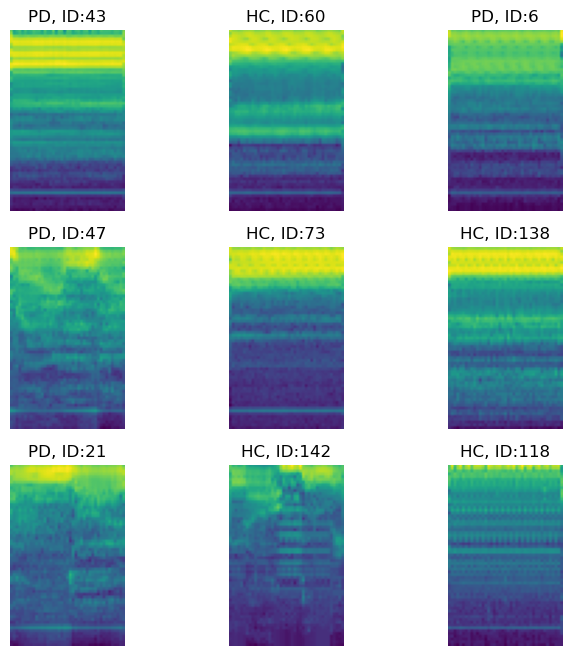

In [7]:
DATASET_SIZE=extension_DB['Segments'].sum()
BATCH_SIZE=9

dataloader = DataLoader(datasetAudio, batch_size=BATCH_SIZE, shuffle=True)

spectrogram_batch, label_batch, subject_batch = next(iter(dataloader))


figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1,BATCH_SIZE+1):
    sample_idx= i-1
    img = spectrogram_batch[sample_idx]
    # print(img.shape)
    label=label_batch[sample_idx]
    subject=subject_batch[sample_idx]
    figure.add_subplot(rows, cols, i)
    if label:
        title='PD'
    else:
        title='HC'
    plt.title('{}, ID:{}'.format(title,subject))
    plt.axis("off")
    plt.imshow(img.squeeze())
    

3. Demostración dentro de un bucle de entrenamiento

In [8]:
BATCH_SIZE=10 # 32
iters=int(DATASET_SIZE/BATCH_SIZE)

dataloader = DataLoader(datasetAudio, batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(2):
    print("epoch {}/2".format(epoch+1,end='\n'))
    for i in range(iters):
        print("batch {}/{}, epoch {}".format(i+1, iters, epoch+1), end='\n')
        spectrogram_batch, label_batch, subject_batch = next(iter(dataloader))
        print("---------------------------------------------------")
        
    print("#################################################")
    

        

epoch 1/2
batch 1/149, epoch 1
fetched segment of audio HC_A1_0140.wav
fetched segment of audio PD_BURRO_0019.wav
fetched segment of audio PD_A2_0058.wav
fetched segment of audio PD_I2_0041.wav
fetched segment of audio HC_ESPONTANEA_0082.wav
fetched segment of audio PD_CALLE_0015.wav
fetched segment of audio PD_CALLE_0015.wav
fetched segment of audio HC_ESPONTANEA_0082.wav
fetched segment of audio PD_E2_0066.wav
fetched segment of audio HC_PATAKA_0129.wav
---------------------------------------------------
batch 2/149, epoch 1
fetched segment of audio HC_SOMBRA_0056.wav
fetched segment of audio HC_BURRO_0049.wav
fetched segment of audio PD_CALLE_0015.wav
fetched segment of audio HC_SOMBRA_0081.wav
fetched segment of audio PD_ABLANDADA_0077.wav
fetched segment of audio HC_O1_0053.wav
fetched segment of audio HC_SOMBRA_0132.wav
fetched segment of audio PD_I2_0041.wav
fetched segment of audio PD_A3_0033.wav
fetched segment of audio HC_ESPONTANEA_0082.wav
----------------------------------

BATCH 1 EPOCH 1

    fetched segment of audio PD_O3_0006.wav
    fetched segment of audio HC_O2_0129.wav
    fetched segment of audio HC_A1_0140.wav
    fetched segment of audio HC_ESPONTANEA_0082.wav
    fetched segment of audio HC_PATAKA_0129.wav
    fetched segment of audio HC_MANGA_0049.wav
    fetched segment of audio PD_I1_0109.wav
    fetched segment of audio HC_PERRO_0060.wav
    fetched segment of audio PD_CALLE_0015.wav
    fetched segment of audio HC_DIABLO_0036.wav 

BATCH 1 EPOCH 2

    fetched segment of audio HC_DIABLO_0036.wav
    fetched segment of audio PD_E2_0039.wav
    fetched segment of audio PD_DIABLO_0010.wav
    fetched segment of audio HC_TOMAS_0074.wav
    fetched segment of audio HC_E2_0082.wav
    fetched segment of audio PD_E2_0024.wav
    fetched segment of audio PD_A1_0018.wav
    fetched segment of audio PD_E1_0043.wav
    fetched segment of audio PD_I1_0109.wav
    fetched segment of audio HC_ESPONTANEA_0118.wav
    
They are shuffled

